In [1]:
from fastai import *
from fastai.tabular import *
from fastai.text import *

In [2]:
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import random

In [3]:
#use this cell when working online
path = '/floyd/home/ed-triage'
data_path = '/floyd/home/data/combined'
model_path = 'floyd/home/models'

In [ ]:
#use this cell in google colab
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/ML_data'
data = pd.read_csv('/content/drive/My Drive/ML_data/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [4]:
data = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [5]:
data = data[['CleanSubjectiveNotes','CleanMedicalHistory', 'outcome', 'target', 'service', 'target2',
       'discharge', 'target3', 'dispo', 'target4', 'ICUvsother', 'target5']]

In [6]:
data.columns, data.shape

(Index(['CleanSubjectiveNotes', 'CleanMedicalHistory', 'outcome', 'target',
        'service', 'target2', 'discharge', 'target3', 'dispo', 'target4',
        'ICUvsother', 'target5'],
       dtype='object'), (165957, 12))

In [7]:
data.dropna(subset = ['CleanSubjectiveNotes','CleanMedicalHistory'], inplace = True)
data.shape

(165433, 12)

### loading databunches

In [8]:
data_lm = load_data(path,'combo_subjnote_lmdb')
data_clas = load_data(path, 'combo_subjnote_2clsdb')

#adding a line to also do backwards languange model for later ensembling
data_lm_bwd = load_data(path, 'combo_subjnote_lmdb', backwards=True)
data_clas_bwd = load_data(path, 'combo_subjnote_2clsdb', backwards=True)

### Now on to training the classifier


In [9]:
f1 = FBeta(beta=1, average = 'weighted')
def train_triage_classifier(encoder_name, datac = data_clas, datal = data_lm, 
                            mets = [accuracy,f1], num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    model = text_classifier_learner(datac, metrics = mets, arch = AWD_LSTM, drop_mult=drop_mult)
    model = model.to_fp16(clip=0.1)
    model.load_encoder(path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

#### first we will do the classifier for subjective notes

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.259393,0.266615,0.902497,0.863880,01:10


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.275566,0.262841,0.903978,0.866117,01:19


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.275580,0.262032,0.904068,0.866122,01:59


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.286219,0.261927,0.904038,0.867065,02:47
1,0.251020,0.261475,0.904310,0.869359,02:42
2,0.267621,0.262013,0.903796,0.867437,02:49
3,0.256632,0.261471,0.903857,0.867939,02:46
4,0.259642,0.261296,0.904189,0.868418,02:45


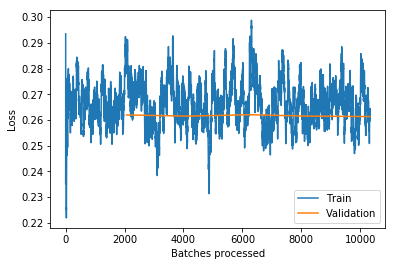

In [22]:
sent_learn = train_triage_classifier('edsent_v4_enc', datac = data_clas, num_cycles = 1, lr = 1e-3)

In [ ]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

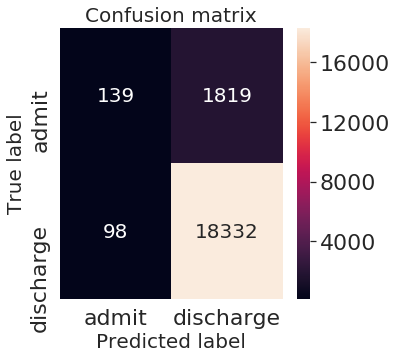

In [ ]:
sns.set(font_scale=2)

LABELS = data_clas.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8712105081031505
f1:           [0.126651 0.950312]
accuracy:     0.9059741024131842
precision:    [0.586498 0.909732]
recall:       [0.070991 0.994683]


In [23]:
sent_learn.save(path + '/models/edsentv4')

#### next we will do the classifier for the medical history

In [12]:
data_lm_2 = load_data(path,'combo_medhx_lmdb')
data_clas_2 = load_data(path, 'combo_medhx_2clsdb')

#adding a line to also do backwards languange model for later ensembling
data_lm_2_bwd = load_data(path, 'combo_medhx_lmdb', backwards=True)
data_clas_2_bwd = load_data(path, 'combo_medhx_2clsdb', backwards =True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.308942,0.294919,0.902587,0.856435,01:19


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.303446,0.293294,0.902436,0.856418,01:44


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.314507,0.293277,0.902466,0.856551,02:58


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.297781,0.293500,0.902497,0.856566,03:57
1,0.290376,0.292568,0.902466,0.856784,03:57
2,0.309309,0.292990,0.902436,0.856711,04:03
3,0.284752,0.292508,0.902436,0.856827,04:09
4,0.289306,0.292662,0.902406,0.856870,04:12


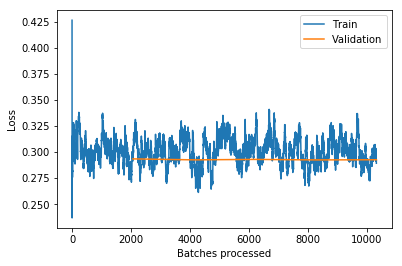

In [14]:
sent_learn = train_triage_classifier('edsent_v4medhx_enc_fwd', datac = data_clas_2, datal = data_lm_2, num_cycles = 1, lr = 1e-3)

In [19]:
sent_learn.save(path + '/models/edsentv4_medhx')

In [27]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

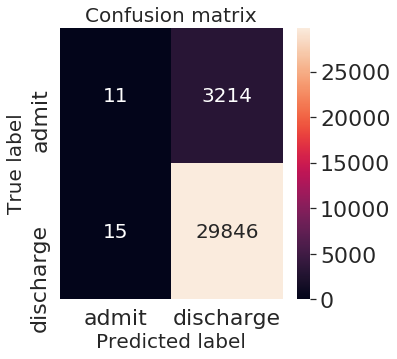

In [28]:
sns.set(font_scale=2)

LABELS = data_clas.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [29]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8568702081440438
f1:           [0.006767 0.948682]
accuracy:     0.902405851417518
precision:    [0.423077 0.902783]
recall:       [0.003411 0.999498]


### now to ensemble and see what happens

In [35]:
#first I'm gonna have to reload my saved model for the medical
reloaded = text_classifier_learner(data_clas, arch = AWD_LSTM);
reloaded.load(path + '/models/edsentv4');

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	size mismatch for 0.module.encoder.weight: copying a param with shape torch.Size([16378, 400]) from checkpoint, the shape in current model is torch.Size([2866, 400]).
	size mismatch for 0.module.encoder_dp.emb.weight: copying a param with shape torch.Size([16378, 400]) from checkpoint, the shape in current model is torch.Size([2866, 400]).

In [21]:
preds1, targets1 = reloaded.get_preds(DatasetType.Valid) 
predictions1 = np.argmax(preds1, axis = 1) 

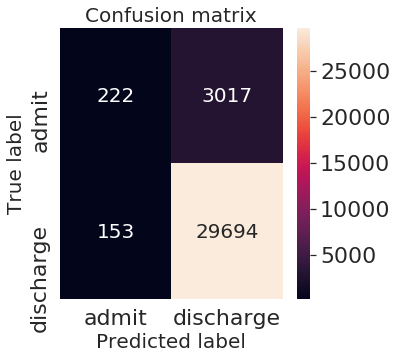

In [22]:
sns.set(font_scale=2)

LABELS = data_clas.classes

confusion_matrix = metrics.confusion_matrix(targets1, predictions1)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [26]:
f1_w = sklearn.metrics.f1_score(targets1, predictions1, average='weighted')
f1 = sklearn.metrics.f1_score(targets1, predictions1, average=None)
acc = sklearn.metrics.accuracy_score(targets1, predictions1)
prec = sklearn.metrics.precision_score(targets1,predictions1, average = None)
rec = sklearn.metrics.recall_score(targets1,predictions1, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8684184508627938
f1:           [0.122856 0.949327]
accuracy:     0.904189082995829
precision:    [0.592    0.907768]
recall:       [0.06854  0.994874]


In [32]:
len(targets), len(targets1)
#targets == targets1

(33086, 33086)

In [34]:
torch.sum(targets == targets1)

tensor(27290)

In [ ]:
#ensembled

final_pred = (preds+preds_b)/2
final_predictions = np.argmax(final_pred, axis = 1) 

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, final_predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, final_predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, final_predictions)
prec = sklearn.metrics.precision_score(targets,final_predictions, average = None)
rec = sklearn.metrics.recall_score(targets,final_predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

In [ ]:
sns.set(font_scale=2)

LABELS = data_clas_bwd.classes

confusion_matrix = metrics.confusion_matrix(targets, final_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()